In [1]:
## importing the libraries
import os
import warnings
import logging
import gc


import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import upsetplot
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from cellink.io import read_sgkit_zarr

warnings.filterwarnings("ignore")
logging.getLogger("matplotlib").setLevel(logging.ERROR)

In [2]:
## definig macros
DEBUG = False
THRESHOLD = 5e-8
TARGET_CHROMOSOME = "22"

In [3]:
## paths
DATA = Path("/home/lollo/Work/hackathon/data/Yazar_OneK1K")
# DATA = Path("/Users/jan.engelmann/projects/sc-eqtl/data")

vcf_file_path = DATA / "OneK1K_imputation_post_qc_r2_08/filter_vcf_r08/chr22.dose.filtered.R2_0.8.vcf.gz"

zarr_path = vcf_file_path.parent.parent / "filter_zarr_r08"
zarr_path.mkdir(exist_ok=True)

icf_file_path = zarr_path / vcf_file_path.with_suffix(".icf").name
zarr_file_path = (zarr_path / vcf_file_path.stem).with_suffix(".vcz")

gene_annotation_path = DATA / "gene_annotation.csv"

if DEBUG:
    scdata_path = DATA / "debug_OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad"
    scdata_annotated_path = DATA / "debug_OneK1K_cohort_gene_expression_matrix_14_celltypes_filtered_annotated.h5ad"
else:
    scdata_path = DATA / "OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz"
    scdata_annotated_path = DATA / "OneK1K_cohort_gene_expression_matrix_14_celltypes_filtered_annotated.h5ad.gz"

dump_path = "/home/lollo/Work/hackathon/dump/eqtl_results.csv"

print(gene_annotation_path, zarr_file_path, scdata_path)

/home/lollo/Work/hackathon/data/Yazar_OneK1K/gene_annotation.csv /home/lollo/Work/hackathon/data/Yazar_OneK1K/OneK1K_imputation_post_qc_r2_08/filter_zarr_r08/chr22.dose.filtered.R2_0.8.vcz /home/lollo/Work/hackathon/data/Yazar_OneK1K/OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz


In [4]:
## defining data paths
dump_path = "/home/lollo/Work/hackathon/dump/eqtl_results.csv"
dump_path_all_ct = "/home/lollo/Work/hackathon/dump/eqtl_all_variants"
plot_path = "/home/lollo/Work/hackathon/plots/"

In [5]:
## loading eqtl results in memory
eqtl_results_df = pd.read_csv(dump_path)
eqtl_results_df

,target_gene,no_tested_variants,min_pv,min_pv_variant,cell_label
0,ENSG00000100181,3610,7.228329e-04,22_18023967_C_T,CD4 ET
1,ENSG00000237438,5477,1.334024e-06,22_18108950_G_C,CD4 ET
2,ENSG00000273203,5523,6.023389e-20,22_18407351_C_T,CD4 ET
3,ENSG00000177663,5697,9.817448e-05,22_18481822_G_C,CD4 ET
4,ENSG00000069998,5889,1.132846e-04,22_18411238_C_G,CD4 ET
...,...,...,...,...,...
2181,ENSG00000205560,5644,4.303679e-20,22_17224835_A_G,Plasma
2182,ENSG00000100288,5586,8.078578e-04,22_17494000_T_C,Plasma
2183,ENSG00000205559,5571,6.818569e-04,22_18466779_G_A,Plasma
2184,ENSG00000100299,5350,3.287313e-04,22_17350075_A_G,Plasma


In [6]:
## correcting p-value
eqtl_results_df["bf_pv"] = np.clip(eqtl_results_df["min_pv"] * eqtl_results_df["no_tested_variants"], 0, 1)
eqtl_results_df["bf_pv_reject"] = eqtl_results_df["bf_pv"] < THRESHOLD
## subsetting the results to only the significant variants
eqtl_significant_variants_results_df = eqtl_results_df[eqtl_results_df["bf_pv_reject"] == True]
eqtl_significant_variants_results_df

,target_gene,no_tested_variants,min_pv,min_pv_variant,cell_label,bf_pv,bf_pv_reject
2,ENSG00000273203,5523,6.023389e-20,22_18407351_C_T,CD4 ET,3.326718e-16,True
7,ENSG00000182902,6648,9.593141e-15,22_17489281_A_C,CD4 ET,6.377520e-11,True
15,ENSG00000183785,7925,8.478988e-17,22_17581170_C_T,CD4 ET,6.719598e-13,True
18,ENSG00000100033,8217,3.291373e-19,22_17666437_A_T,CD4 ET,2.704521e-15,True
19,ENSG00000237517,8473,5.301734e-25,22_17977198_A_G,CD4 ET,4.492159e-21,True
...,...,...,...,...,...,...,...
2136,ENSG00000182257,9783,1.178732e-15,22_17702201_A_C,Plasma,1.153154e-11,True
2137,ENSG00000273289,9751,6.325645e-19,22_19763540_G_C,Plasma,6.168137e-15,True
2157,ENSG00000100427,9008,4.383918e-12,22_19011655_G_A,Plasma,3.949033e-08,True
2178,ENSG00000272666,5757,3.284699e-13,22_17784364_G_T,Plasma,1.891001e-09,True


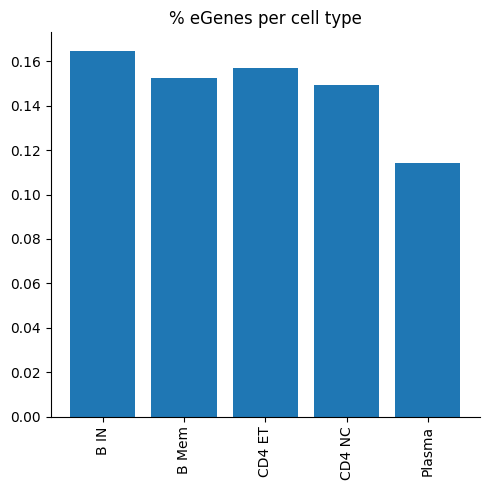

In [7]:
## barplot of counts
## TODO: FIX CMAP
# ## getting the number of eGenes per cell type
counts_df = pd.DataFrame(eqtl_results_df.groupby("cell_label").size().reset_index().rename(columns={0: "count"}))
counts_sign_df = pd.DataFrame(
    eqtl_significant_variants_results_df.groupby("cell_label").size().reset_index().rename(columns={0: "count"})
)
fig, axes = plt.subplots(figsize=(5, 5))
axes.spines[["top", "right"]].set_visible(False)
axes.bar(counts_df["cell_label"], height=counts_sign_df["count"] / counts_df["count"])
axes.tick_params(axis="x", labelrotation=90)
title = axes.set_title(r"% eGenes per cell type")
fig.tight_layout()
fig.savefig(os.path.join(plot_path, "pct_eGenes_per_cell_type_bfpv.png"), dpi=300, bbox_inches="tight")

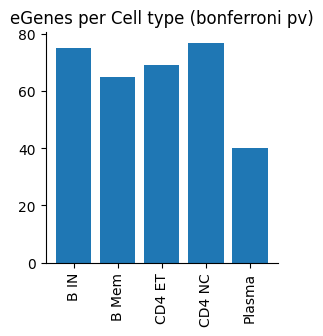

In [8]:
## barplot of counts
## TODO: FIX CMAP
# ## getting the number of eGenes per cell type
counts_df = pd.DataFrame(
    eqtl_significant_variants_results_df.groupby("cell_label").size().reset_index().rename(columns={0: "count"})
)
fig, axes = plt.subplots(figsize=(3, 3))
axes.spines[["top", "right"]].set_visible(False)
axes.bar(counts_df["cell_label"], height=counts_df["count"])
axes.tick_params(axis="x", labelrotation=90)
title = axes.set_title("eGenes per Cell type (bonferroni pv)")
# fig.savefig(os.path.join(plot_path, "eGenes_per_cell_type_bfpv.png"), dpi = 300)

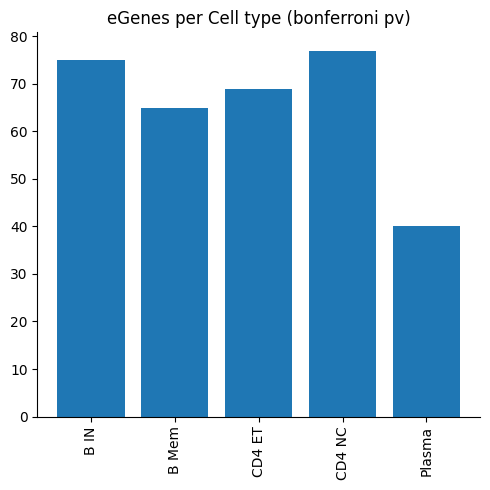

In [9]:
## barplot of counts
## TODO: FIX CMAP
# ## getting the number of eGenes per cell type
counts_df = pd.DataFrame(
    eqtl_significant_variants_results_df.groupby("cell_label").size().reset_index().rename(columns={0: "count"})
)
fig, axes = plt.subplots(figsize=(5, 5))
axes.spines[["top", "right"]].set_visible(False)
axes.bar(counts_df["cell_label"], height=counts_df["count"])
axes.tick_params(axis="x", labelrotation=90)
title = axes.set_title("eGenes per Cell type (bonferroni pv)")
fig.tight_layout()
fig.savefig(os.path.join(plot_path, "eGenes_per_cell_type_bfpv.png"), dpi=300, bbox_inches="tight")

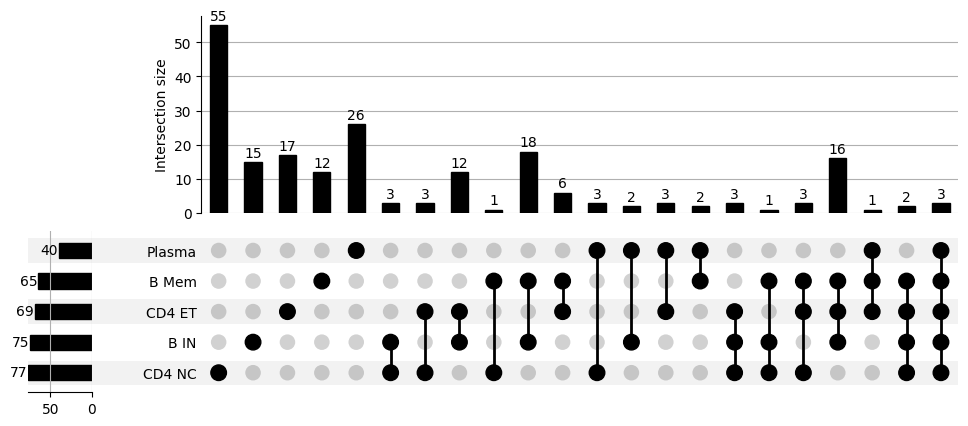

In [10]:
## upset plot
egenes_cell_type = eqtl_significant_variants_results_df.groupby("cell_label")
egenes_dict = {}
for cell_type, group in egenes_cell_type:
    egenes = set(group["target_gene"])
    egenes_dict[cell_type] = egenes
egenes_results = upsetplot.from_contents(egenes_dict)
ax_dict = upsetplot.UpSet(
    egenes_results,
    subset_size="count",
    show_counts=True,
).plot()

In [11]:
cells_to_analyse = ["CD4 ET", "CD4 NC", "CD8 S100B", "CD8 ET", "B IN", "CD8 NC", "B Mem", "Plasma"]
cells_to_analyse = ["CD4 ET", "CD4 NC", "B IN", "B Mem", "Plasma"]

In [12]:
cell_groups = {
    "CD4_8": ["CD4 ET", "CD4 NC", "CD8 S100B", "CD8 ET", "CD8 NC"],
}
egenes_cell_type = eqtl_significant_variants_results_df.groupby("cell_label")
for key, cell_group in cell_groups.items():
    overlapping_egenes = np.zeros((len(cell_group), len(cell_group)))
    for idx, cell_type in enumerate(cell_group):
        group = egenes_cell_type.get_group(cell_type)
        egenes = set(group["target_gene"])
        for idx_, cell_type_ in enumerate(cell_group):
            group_ = egenes_cell_type.get_group(cell_type_)
            egenes_ = set(group_["target_gene"])
            ## retrieveing overlap
            # pct_overlap_egenes_ = len(egenes.intersection(egenes_))/len(egenes)
            pct_overlap_egenes_ = len(egenes.intersection(egenes_)) / len(egenes.union(egenes_))
            overlapping_egenes[idx, idx_] = pct_overlap_egenes_
    ## heatmap
    fig, axes = plt.subplots(figsize=(5, 5))
    # Getting the Upper Triangle of the co-relation matrix
    mask = np.tril(overlapping_egenes)
    mask = None
    sns.heatmap(overlapping_egenes, xticklabels=cell_group, yticklabels=cell_group, ax=axes, mask=mask, cmap="Reds")
    title = axes.set_title("% Overlapping eGenes per cell type")
    fig.tight_layout()
    fig.savefig(os.path.join(plot_path, f"overlapping_eGenes_per_cell_{key}.png"), dpi=300, bbox_inches="tight")

KeyError: 'CD8 S100B'

In [ ]:
cell_groups = {"CD4": ["CD4 ET", "CD4 NC"], "CD8": ["CD8 S100B", "CD8 ET", "CD8 NC"], "B": ["B IN", "B Mem", "Plasma"]}
egenes_cell_type = eqtl_significant_variants_results_df.groupby("cell_label")
for key, cell_group in cell_groups.items():
    overlapping_egenes = np.zeros((len(cell_group), len(cell_group)))
    for idx, cell_type in enumerate(cell_group):
        group = egenes_cell_type.get_group(cell_type)
        egenes = set(group["target_gene"])
        for idx_, cell_type_ in enumerate(cell_group):
            group_ = egenes_cell_type.get_group(cell_type_)
            egenes_ = set(group_["target_gene"])
            ## retrieveing overlap
            pct_overlap_egenes_ = len(egenes.intersection(egenes_)) / len(egenes)  # /len(egenes.union(egenes_))
            overlapping_egenes[idx, idx_] = pct_overlap_egenes_
    ## heatmap
    fig, axes = plt.subplots(figsize=(5, 5))
    # Getting the Upper Triangle of the co-relation matrix
    mask = np.tril(overlapping_egenes)
    mask = None
    sns.heatmap(overlapping_egenes, xticklabels=cell_group, yticklabels=cell_group, ax=axes, mask=mask, cmap="Reds")
    title = axes.set_title("% Overlapping eGenes per cell type")
    fig.tight_layout()
    fig.savefig(os.path.join(plot_path, f"overlapping_eGenes_per_cell_{key}.png"), dpi=300, bbox_inches="tight")

In [ ]:
## upset plot
egenes_cell_type = eqtl_significant_variants_results_df.groupby("cell_label")
overlapping_egenes = np.zeros((len(cells_to_analyse), len(cells_to_analyse)))
cell_types = [e[0] for e in egenes_cell_type]
for idx, cell_type in enumerate(cells_to_analyse):
    group = egenes_cell_type.get_group(cell_type)
    egenes = set(group["target_gene"])
    for idx_, cell_type_ in enumerate(cells_to_analyse):
        group_ = egenes_cell_type.get_group(cell_type_)
        egenes_ = set(group_["target_gene"])
        ## retrieveing overlap
        # pct_overlap_egenes_ = len(egenes.intersection(egenes_))/len(egenes)
        pct_overlap_egenes_ = len(egenes.intersection(egenes_)) / len(egenes.union(egenes_))
        overlapping_egenes[idx, idx_] = pct_overlap_egenes_
## heatmap
fig, axes = plt.subplots(figsize=(5, 5))
# Getting the Upper Triangle of the co-relation matrix
mask = np.tril(overlapping_egenes)
mask = None
sns.heatmap(
    overlapping_egenes, xticklabels=cells_to_analyse, yticklabels=cells_to_analyse, ax=axes, mask=mask, cmap="Reds"
)
title = axes.set_title("% Overlapping eGenes per cell type")
fig.tight_layout()
fig.savefig(os.path.join(plot_path, "overlapping_eGenes_per_cell.png"), dpi=300, bbox_inches="tight")

In [ ]:
# ## aggregating the data by cell by gene and getting the significant variates
# results_dict = {}
# cells_to_analyse = ["CD4 ET","CD4 NC","CD8 S100B","CD8 ET","B IN","CD8 NC","B Mem","Plasma"]
# for cell in tqdm(cells_to_analyse):
#     cell_results = {}
#     csv_path = os.path.join(dump_path_all_ct, f"{cell}.csv")
#     cell_df = pd.read_csv(csv_path)
#     ## fixing the problem with how the data was stored
#     #print(cell, cell_df["pv"].dtype, end = "...")
#     if cell_df["pv"].dtype != float : cell_df["pv"] = cell_df["pv"].map(lambda e: float(e[1: -1]) if isinstance(e, str) else 1.0)
#     if cell_df["betasnp"].dtype != float : cell_df["betasnp"] = cell_df["betasnp"].map(lambda e: float(e[1: -1])if isinstance(e, str) else e)
#     if cell_df["betasnp_ste"].dtype != float: cell_df["betasnp_ste"] = cell_df["betasnp_ste"].map(lambda e: float(e[1: -1]) if isinstance(e, str) else e)
#     if cell_df["lrt"].dtype != float: cell_df["lrt"] = cell_df["lrt"].map(lambda e: float(e[1: -1]) if isinstance(e, str) else e)
#     #print(cell_df["pv"].dtype)
#     ## computing the adjusted bonferroni p value
#     cell_df["bf_pv"] = np.clip(cell_df["pv"]*cell_df["no_tested_variants"], 0, 1)
#     cell_significant_df = cell_df[cell_df["bf_pv"] < THRESHOLD]
#     target_genes = cell_significant_df["target_gene"].unique()
#     for gene in target_genes:
#         cell_gene_df = cell_df[cell_df["target_gene"] == gene]
#         significant_variants = cell_gene_df["variant"].unique()
#         cell_results[gene] = significant_variants
#     results_dict[cell] = cell_results
# print(results_dict)

In [ ]:
## retrieving genetic data
gdata = read_sgkit_zarr(zarr_file_path)
gdata.obs = gdata.obs.set_index("id")
gdata

In [ ]:
## reading single cell data
scdata = ad.read_h5ad(scdata_path)
scdata

In [ ]:
## adding column needed to match the annotated data
scdata.var["ensembl_gene_id"] = scdata.var_names
scdata.var
## reading annotation data
annotation_df = pd.read_csv(gene_annotation_path).loc[
    :, ["ensembl_gene_id", "start_position", "end_position", "chromosome_name"]
]
annotation_df = annotation_df.loc[annotation_df.ensembl_gene_id.isin(scdata.var_names)]
annotation_df
## merging the scdata.var df with the annotations
merged_df = scdata.var.merge(annotation_df, on="ensembl_gene_id")
merged_df = merged_df.rename(
    columns={"ensembl_gene_id": "Geneid", "start_position": "start", "end_position": "end", "chromosome_name": "chrom"}
)
merged_df.index = merged_df["Geneid"]
merged_df = merged_df.drop(["Geneid"], axis=1)
scdata.var = merged_df
scdata.var

In [ ]:
# for cell_label in scdata.obs.cell_label.unique():
for idx, cell_label in enumerate(cells_to_analyse):
    ## defining the dump directory for the current cell
    cell_plots_dir = os.path.join(plot_path, f"boxplots/{cell_label}")
    os.mkdir(cell_plots_dir)
    ## subsetting the scdata over the current cell_label
    scdata_cell = scdata[scdata.obs.cell_label == cell_label]
    ## normalizing counts
    sc.pp.normalize_total(scdata_cell)
    sc.pp.log1p(scdata_cell)
    sc.pp.normalize_total(scdata_cell)
    scdata_cell = scdata_cell[:, scdata_cell.var["chrom"] == TARGET_CHROMOSOME]
    ## aggregating the data
    pbdata = sc.get.aggregate(scdata_cell, "individual", "mean")
    gdata_cell = gdata[pbdata.obs.index]
    pbdata.X = pbdata.layers["mean"]
    ## retrieving the eqtl results for the current cell type
    eqtl_results_cell = eqtl_significant_variants_results_df[eqtl_results_df["cell_label"] == cell_label]
    ## defining iterator
    iterator = tqdm(eqtl_results_cell["target_gene"].unique())
    ## iterating over each target gene
    for gene in eqtl_results_cell["target_gene"].unique():
        ## retrieving the index of the current gene that is processed
        gene_idx = np.argwhere(pbdata.var_names == gene)[0]
        ## retrieving the mean gene expression from the patient data
        mean_gene_expression = pbdata.X[:, gene_idx[0]]
        ## retrieving the results of the eqtl for the current gene
        eqtl_results_cell_gene = eqtl_results_cell[eqtl_results_cell["target_gene"] == gene]
        min_var = eqtl_results_cell_gene["min_pv_variant"].unique()[0]
        ## retrieving the index of the variate for getting its allele diff
        min_var_idx = np.argwhere(gdata_cell.var_names == min_var)[0]
        min_var_allele_diff = gdata_cell.X[:, min_var_idx[0]]
        min_var_allele_diff = ad.utils.asarray(min_var_allele_diff)
        ## constructing data frame with current data (probably not necessary but im just too dumb now)
        gene_cell_expr_all_df = pd.DataFrame({"gene_exp": mean_gene_expression, "allele": min_var_allele_diff})
        ## do plot and save it
        fig, axes = plt.subplots(figsize=(3, 3))
        axes.get_yaxis().set_visible(False)
        title = axes.set_title(f"{cell_label}-{gene}")
        sns.boxplot(data=gene_cell_expr_all_df, x="allele", y="gene_exp", ax=axes)
        fig.tight_layout()
        fig.savefig(os.path.join(cell_plots_dir, f"{gene}.png"), dpi=300, bbox_inches="tight")
        iterator.set_description(f"{idx}/{len(cells_to_analyse)}")
        iterator.update()
        del min_var_allele_diff
        gc.collect()
    del pbdata, gdata_cell
    gc.collect()

In [ ]:
# for cell_label in scdata.obs.cell_label.unique():
for idx, cell_label in enumerate(cells_to_analyse):
    ## defining the dump directory for the current cell
    cell_plots_dir = os.path.join(plot_path, "boxplot_new")
    # os.mkdir(cell_plots_dir)
    ## subsetting the scdata over the current cell_label
    scdata_cell = scdata[scdata.obs.cell_label == cell_label]
    # normalizing counts
    sc.pp.normalize_total(scdata_cell)
    sc.pp.log1p(scdata_cell)
    sc.pp.normalize_total(scdata_cell)
    scdata_cell = scdata_cell[:, scdata_cell.var["chrom"] == TARGET_CHROMOSOME]
    ## aggregating the data
    pbdata = sc.get.aggregate(scdata_cell, "individual", "mean")
    gdata_cell = gdata[pbdata.obs.index]
    pbdata.X = pbdata.layers["mean"]
    ## retrieving the eqtl results for the current cell type
    eqtl_results_cell = eqtl_significant_variants_results_df[eqtl_results_df["cell_label"] == cell_label]
    ## most significant gene
    most_significant_variant_gene_comb = eqtl_results_cell.sort_values("bf_pv", key=lambda e: -e).iloc[0, :]
    most_significant_gene = most_significant_variant_gene_comb["target_gene"]
    gene_idx = np.argwhere(pbdata.var_names == most_significant_gene)[0]
    ## retrieving the mean gene expression from the patient data
    mean_gene_expression = pbdata.X[:, gene_idx[0]]
    ## retrieving the results of the eqtl for the current gene
    # eqtl_results_cell_gene = eqtl_results_cell[eqtl_results_cell["target_gene"] == most_significant_gene]
    min_var = most_significant_variant_gene_comb["min_pv_variant"]
    ## retrieving the index of the variate for getting its allele diff
    min_var_idx = np.argwhere(gdata_cell.var_names == min_var)[0]
    min_var_allele_diff = gdata_cell.X[:, min_var_idx[0]]
    min_var_allele_diff = ad.utils.asarray(min_var_allele_diff)
    ## constructing data frame with current data (probably not necessary but im just too dumb now)
    gene_cell_expr_all_df = pd.DataFrame({"gene_exp": mean_gene_expression, "allele": min_var_allele_diff})
    ## do plot and save it
    fig, axes = plt.subplots(figsize=(3, 3))
    axes.get_yaxis().set_visible(False)
    title = axes.set_title(f"{cell_label}-{most_significant_gene}")
    sns.boxplot(data=gene_cell_expr_all_df, x="allele", y="gene_exp", ax=axes)
    fig.tight_layout()
    fig.savefig(os.path.join(cell_plots_dir, f"{cell_label}_{most_significant_gene}.png"), dpi=300, bbox_inches="tight")
    # print(eqtl_results_cell.shape)
    ## defining iterator
    # iterator = tqdm(eqtl_results_cell["target_gene"].unique())
    # break
    # ## iterating over each target gene
    # for gene in eqtl_results_cell["target_gene"].unique():
    #     ## retrieving the index of the current gene that is processed
    #     gene_idx = np.argwhere(pbdata.var_names == gene)[0]
    #     ## retrieving the mean gene expression from the patient data
    #     mean_gene_expression = pbdata.X[:, gene_idx[0]]
    #     ## retrieving the results of the eqtl for the current gene
    #     eqtl_results_cell_gene = eqtl_results_cell[eqtl_results_cell["target_gene"] == gene]
    #     min_var = eqtl_results_cell_gene["min_pv_variant"].unique()[0]
    #     ## retrieving the index of the variate for getting its allele diff
    #     min_var_idx = np.argwhere(gdata_cell.var_names == min_var)[0]
    #     min_var_allele_diff = gdata_cell.X[:, min_var_idx[0]]
    #     min_var_allele_diff = ad.utils.asarray(min_var_allele_diff)
    #     ## constructing data frame with current data (probably not necessary but im just too dumb now)
    #     gene_cell_expr_all_df = pd.DataFrame({"gene_exp": mean_gene_expression, "allele": min_var_allele_diff})
    #     ## do plot and save it
    #     fig, axes = plt.subplots(figsize = (3, 3))
    #     axes.get_yaxis().set_visible(False)
    #     title = axes.set_title(f"{cell_label}-{gene}")
    #     sns.boxplot(data=gene_cell_expr_all_df, x="allele", y="gene_exp", ax = axes)
    #     fig.tight_layout()
    #     fig.savefig(os.path.join(cell_plots_dir, f"{gene}.png"), dpi = 300, bbox_inches = "tight")
    #     iterator.set_description(f"{idx}/{len(cells_to_analyse)}")
    #     iterator.update()
    #     del min_var_allele_diff
    #     gc.collect()
    # del pbdata, gdata_cell
    # gc.collect()